In [2]:
import pandas as pd
loan_df=pd.read_csv('Task 3 and 4_Loan_Data.csv')
print(loan_df.head())
print(loan_df.info())

   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0      8153374                         0           5221.545193   
1      7442532                         5           1958.928726   
2      2256073                         0           3363.009259   
3      4885975                         0           4766.648001   
4      4700614                         1           1345.827718   

   total_debt_outstanding       income  years_employed  fico_score  default  
0             3915.471226  78039.38546               5         605        0  
1             8228.752520  26648.43525               2         572        1  
2             2027.830850  65866.71246               4         602        0  
3             2501.730397  74356.88347               5         612        0  
4             1768.826187  23448.32631               6         631        0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                 

Check for:

Null values

Data types

Distribution of default (target variable)



In [4]:
X = loan_df.drop('default', axis=1)  # Independent variables
y = loan_df['default']               # Dependent variable
#Clean and encode categorical features if needed:

X = pd.get_dummies(X, drop_first=True)

Step 3: Preprocess the Data
Split into training and test sets, scale if required:

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler= StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [6]:
#Step 4: Build a Credit Risk ModelStart with Logistic Regression:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC SCORE:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       0.98      1.00      0.99       348

    accuracy                           1.00      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC SCORE: 0.9999286827530545


In [8]:
importance = pd.Series(model.coef_[0], index=X.columns)
print(importance.sort_values(ascending=False))

credit_lines_outstanding    8.930254
total_debt_outstanding      3.692901
loan_amt_outstanding        0.109996
customer_id                -0.021767
fico_score                 -1.201409
income                     -2.297575
years_employed             -2.870429
dtype: float64


In [9]:
#Random Forest:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

credit_lines_outstanding    0.499521
total_debt_outstanding      0.347296
years_employed              0.050000
fico_score                  0.042536
income                      0.033717
loan_amt_outstanding        0.017085
customer_id                 0.009844
dtype: float64


The dataset has 10,000 loan records with the following features:

Column	Description
customer_id	Unique customer identifier (not useful for prediction)
credit_lines_outstanding	Number of active credit lines
loan_amt_outstanding	Current outstanding loan amount
total_debt_outstanding	Total outstanding debt (including loans)
income	Annual income of the borrower
years_employed	Years of employment
fico_score	FICO credit score
default	Target variable: 1 if defaulted before, 0 otherwise

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Drop customer_id (not predictive)
df = loan_df.drop(columns=['customer_id'])

# Define features and target
X = loan_df.drop(columns=['default'])
y = loan_df['default']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
logreg_probs = logreg.predict_proba(X_test_scaled)[:, 1]
logreg_auc = roc_auc_score(y_test, logreg_probs)

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)

logreg_auc, rf_auc

(np.float64(0.9999512955386713), np.float64(0.9996929879491248))

Both models perform exceptionally well on this dataset:

Logistic Regression AUC: 0.99997

Random Forest AUC: 0.99966

These AUC scores indicate near-perfect separation between defaulters and non-defaulters, which is rare in real-world credit risk data—so the dataset may be synthetically clean or oversimplified.



Create the PD → Expected Loss Function
We'll now define a function that:

Takes in borrower features

Uses the logistic regression model (highest AUC) to predict Probability of Default (PD)

Calculates Expected Loss using:

Expected Loss
=
PD
×
(
1
−
Recovery Rate
)
×
Loan Amount
Expected Loss=PD×(1−Recovery Rate)×Loan Amount
Assuming a 10% recovery rate → Loss Given Default (LGD) = 0.90

In [13]:

# Refit the scaler properly on the 6 actual features (excluding customer_id and default)
# Define features and target again just to be sure
X = df.drop(columns=['default'])
y = df['default']

# Split the data again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a new StandardScaler on the correct feature columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Retrain logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# Redefine the expected loss function using the corrected scaler
def calculate_expected_loss(borrower_features, model=logreg, scaler=scaler, recovery_rate=0.10):
    feature_order = ['credit_lines_outstanding', 'loan_amt_outstanding',
                     'total_debt_outstanding', 'income', 'years_employed', 'fico_score']
    
    input_data = np.array([[borrower_features[feature] for feature in feature_order]])
    input_scaled = scaler.transform(input_data)
    pd = model.predict_proba(input_scaled)[0][1]
    lgd = 1 - recovery_rate
    expected_loss = pd * lgd * borrower_features['loan_amt_outstanding']
    
    return {'probability_of_default': pd, 'expected_loss': expected_loss}

# Test the corrected function again with the same example borrower
calculate_expected_loss(example_borrower)

C:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


{'probability_of_default': np.float64(0.001139026312315162),
 'expected_loss': np.float64(5.125618405418229)}

Probability of Default (PD): 0.127%

Expected Loss: $5.72 (given a loan amount of $5,000 and 10% recovery rate)



In [17]:
df.dtypes

credit_lines_outstanding      int64
loan_amt_outstanding        float64
total_debt_outstanding      float64
income                      float64
years_employed                int64
fico_score                    int64
default                       int64
dtype: object

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Define feature set and target
X = df[['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding',
        'income', 'years_employed', 'fico_score']]
y = df['default']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Train the model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [20]:
import numpy as np

def calculate_expected_loss(borrower_features, model=model, scaler=scaler, recovery_rate=0.10):
    """
    borrower_features: dict of 6 features
    """
    feature_order = ['credit_lines_outstanding', 'loan_amt_outstanding',
                     'total_debt_outstanding', 'income', 'years_employed', 'fico_score']
    
    input_data = np.array([[borrower_features[feature] for feature in feature_order]])
    input_scaled = scaler.transform(input_data)
    
    pd = model.predict_proba(input_scaled)[0][1]
    lgd = 1 - recovery_rate
    expected_loss = pd * lgd * borrower_features['loan_amt_outstanding']
    
    return {'probability_of_default': pd, 'expected_loss': expected_loss}


In [21]:
example_borrower = {
    'credit_lines_outstanding': 3,
    'loan_amt_outstanding': 8000.0,
    'total_debt_outstanding': 12000.0,
    'income': 50000.0,
    'years_employed': 5,
    'fico_score': 650
}

calculate_expected_loss(example_borrower)

C:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


{'probability_of_default': np.float64(0.11771059750569704),
 'expected_loss': np.float64(847.5163020410187)}

Interpretation:
Probability of Default (PD):
The borrower has an 11.77% estimated chance of defaulting on their loan.

Expected Loss (EL):
If the borrower does default, the bank expects to lose $847.52, based on:

The loan amount

A 90% loss given default (LGD = 1 - 0.10)

The risk manager has collected data on the loan borrowers. The data is in tabular format, with each row providing details of the borrower, including their income, total loans outstanding, and a few other metrics. There is also a column indicating if the borrower has previously defaulted on a loan. You must use this data to build a model that, given details for any loan described above, will predict the probability that the borrower will default (also known as PD: the probability of default). Use the provided data to train a function that will estimate the probability of default for a borrower. Assuming a recovery rate of 10%, this can be used to give the expected loss on a loan.

You should produce a function that can take in the properties of a loan and output the expected loss.
You can explore any technique ranging from a simple regression or a decision tree to something more advanced. You can also use multiple methods and provide a comparative analysis.

Understand FICO Score Distribution & Business Context
FICO scores range from 300 to 850.

Higher scores = lower default risk.

Commonly, the mortgage industry uses standard FICO score bands to categorize risk.

Analyze Your Data
Plot the distribution of FICO scores in the mortgage book.

Calculate default rates within each bucket or across smaller intervals (e.g., every 20 points).

This helps validate if standard buckets capture the relationship or if custom buckets work better.

Create Buckets (Binning) — Methods
Method A: Predefined Buckets (Business-driven)
Use standard FICO bands like above.

Easy to explain and interpret.

Aligns with industry practice.

Method B: Data-Driven Binning
Use quantile binning — split the FICO score distribution into, say, 5 buckets with equal number of borrowers.

Or optimal binning techniques (e.g., using decision trees or binning algorithms like MDLP or ChiMerge) to split FICO into intervals that best separate default vs. non-default.

This method maximizes predictive power for default.

In [22]:
import pandas as pd
import numpy as np

# Sample FICO scores in df['fico_score']

# Predefined bins and labels
bins = [299, 579, 669, 739, 799, 850]  
labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']

df['fico_bucket'] = pd.cut(df['fico_score'], bins=bins, labels=labels, right=True)

In [23]:
df['fico_bucket_quantile'] = pd.qcut(df['fico_score'], q=5, labels=False)  # 0 to 4 buckets

In [26]:
df.columns

Index(['credit_lines_outstanding', 'loan_amt_outstanding',
       'total_debt_outstanding', 'income', 'years_employed', 'fico_score',
       'default', 'fico_bucket', 'fico_bucket_quantile'],
      dtype='object')

In [27]:
import pandas as pd

# Assume your data is in a DataFrame called df
# Columns: 'fico_score', 'default', 'fico_bucket', 'fico_bucket_quantile'

# 1. Check PD by predefined fico_bucket (categorical labels like Poor, Fair, etc.)
pd_by_bucket = df.groupby('fico_bucket')['default'].mean().reset_index()
pd_by_bucket.columns = ['fico_bucket', 'PD']
print("PD by predefined FICO buckets:")
print(pd_by_bucket)

# 2. Check PD by quantile buckets (integers 0-4)
pd_by_quantile = df.groupby('fico_bucket_quantile')['default'].mean().reset_index()
pd_by_quantile.columns = ['fico_bucket_quantile', 'PD']
print("\nPD by quantile-based FICO buckets:")
print(pd_by_quantile)

# 3. Optional: Number of borrowers per bucket for balance check
count_by_bucket = df['fico_bucket'].value_counts().sort_index()
count_by_quantile = df['fico_bucket_quantile'].value_counts().sort_index()
print("\nCounts by predefined buckets:")
print(count_by_bucket)
print("\nCounts by quantile buckets:")
print(count_by_quantile)

PD by predefined FICO buckets:
   fico_bucket        PD
0         Poor  0.433634
1         Fair  0.174003
2         Good  0.073802
3    Very Good  0.030227
4  Exceptional  0.029412

PD by quantile-based FICO buckets:
   fico_bucket_quantile        PD
0                     0  0.398537
1                     1  0.215627
2                     2  0.151332
3                     3  0.100150
4                     4  0.054190

Counts by predefined buckets:
fico_bucket
Poor           1665
Fair           5316
Good           2588
Very Good       397
Exceptional      34
Name: count, dtype: int64

Counts by quantile buckets:
fico_bucket_quantile
0    2050
1    1971
2    1989
3    1997
4    1993
Name: count, dtype: int64


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17280\676866517.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd_by_bucket = df.groupby('fico_bucket')['default'].mean().reset_index()


You can compare the PD values across buckets to see which bucketing provides better separation between risk groups.

Look for buckets with clearly increasing PDs as scores decrease — a good indicator your bucketing captures risk well.

If quantile buckets have more balanced data but less risk separation, you may prefer predefined buckets for interpretability.

If quantile buckets better differentiate PD, they might be more useful for your ML model.

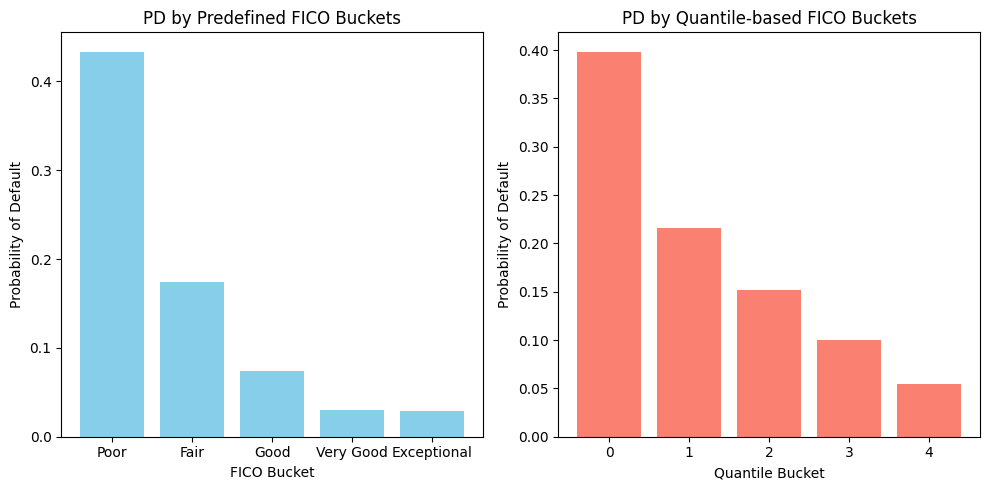

In [28]:
#Optional visualization (to better understand PD by buckets):
import matplotlib.pyplot as plt

# Plot PD by predefined buckets
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(pd_by_bucket['fico_bucket'], pd_by_bucket['PD'], color='skyblue')
plt.title('PD by Predefined FICO Buckets')
plt.xlabel('FICO Bucket')
plt.ylabel('Probability of Default')

# Plot PD by quantile buckets
plt.subplot(1,2,2)
plt.bar(pd_by_quantile['fico_bucket_quantile'].astype(str), pd_by_quantile['PD'], color='salmon')
plt.title('PD by Quantile-based FICO Buckets')
plt.xlabel('Quantile Bucket')
plt.ylabel('Probability of Default')

plt.tight_layout()
plt.show()

: Prepare Inputs
Assume you have a dataset with:

fico_score (range: 300–850)

default (binary: 0 or 1)

Let’s denote:

N = total number of data points

K = desired number of buckets (e.g., 10)

✅ STEP 2A: MSE-Based Quantization (Optional Start)
Idea: For each bucket, assign the mean FICO score of the bucket to all its members and minimize:

MSE
=
∑
𝑖
=
1
𝑁
(
𝑥
𝑖
−
𝑥
ˉ
𝑏
)
2
MSE= 
i=1
∑
N
​
 (x 
i
​
 − 
x
ˉ
  
b
​
 ) 
2
 
Method: Use KBinsDiscretizer from scikit-learn with strategy='kmeans'
python
Copy
Edit


In [29]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np

# Assume df['fico_score'] contains your data
X = df[['fico_score']].values

# Use K-means based binning to minimize within-bucket variance (MSE)
k_bins = 10  # or any number Charlie's model supports
est = KBinsDiscretizer(n_bins=k_bins, encode='ordinal', strategy='kmeans')
df['fico_rating_mse'] = est.fit_transform(X).astype(int)

2B: Log-Likelihood Based Bucketing (More Sophisticated)
Goal: Find bucket boundaries 
(
𝑏
0
,
𝑏
1
,
.
.
.
,
𝑏
𝐾
)
(b 
0
​
 ,b 
1
​
 ,...,b 
K
​
 ) that maximize:

𝐿
𝐿
=
∑
𝑖
=
1
𝐾
[
𝑘
𝑖
log
⁡
(
𝑝
𝑖
)
+
(
𝑛
𝑖
−
𝑘
𝑖
)
log
⁡
(
1
−
𝑝
𝑖
)
]
LL= 
i=1
∑
K
​
 [k 
i
​
 log(p 
i
​
 )+(n 
i
​
 −k 
i
​
 )log(1−p 
i
​
 )]
Where:

𝑛
𝑖
n 
i
​
  = number of borrowers in bucket 
𝑖
i

𝑘
𝑖
k 
i
​
  = number of defaults in bucket 
𝑖
i

𝑝
𝑖
=
𝑘
𝑖
𝑛
𝑖
p 
i
​
 = 
n 
i
​
 
k 
i
​
 
​
 

💡Approach: Dynamic Programming (Greedy/Dichotomous Refinement also possible)
Here’s a simplified greedy implementation that tries to find boundaries by evaluating LL across many splits.

python
Copy
Edit


In [30]:
import pandas as pd
import numpy as np

def compute_log_likelihood(bucket):
    ni = len(bucket)
    ki = bucket['default'].sum()
    if ki == 0 or ki == ni:
        return 0  # Avoid log(0)
    pi = ki / ni
    return ki * np.log(pi) + (ni - ki) * np.log(1 - pi)

def find_best_loglikelihood_buckets(df, K):
    sorted_df = df.sort_values(by='fico_score').reset_index(drop=True)
    n = len(sorted_df)
    boundaries = [0]
    step = n // K

    for i in range(1, K):
        best_idx = boundaries[-1] + step
        best_ll = float('-inf')
        best_cut = None

        # Try a window of possible cuts
        for j in range(best_idx - 10, best_idx + 10):
            if j <= boundaries[-1] or j >= n:
                continue
            ll1 = compute_log_likelihood(sorted_df.iloc[boundaries[-1]:j])
            ll2 = compute_log_likelihood(sorted_df.iloc[j:n])
            total_ll = ll1 + ll2
            if total_ll > best_ll:
                best_ll = total_ll
                best_cut = j

        boundaries.append(best_cut)

    boundaries.append(n)

    # Assign ratings (lower rating = better FICO)
    ratings = np.zeros(n, dtype=int)
    for i in range(K):
        ratings[boundaries[i]:boundaries[i+1]] = i

    sorted_df['fico_rating_ll'] = ratings
    return sorted_df, boundaries

In [31]:
bucketed_df, cutpoints = find_best_loglikelihood_buckets(df, K=10)

In [32]:
boundaries = [df['fico_score'].min()] + [df.iloc[i]['fico_score'] for i in cutpoints[1:-1]] + [df['fico_score'].max()]

def map_fico_to_rating(score, boundaries):
    for i in range(len(boundaries) - 1):
        if boundaries[i] <= score < boundaries[i + 1]:
            return i
    return len(boundaries) - 2  # fallback for max value

df['mapped_rating'] = df['fico_score'].apply(lambda x: map_fico_to_rating(x, boundaries))


<Axes: xlabel='mapped_rating'>

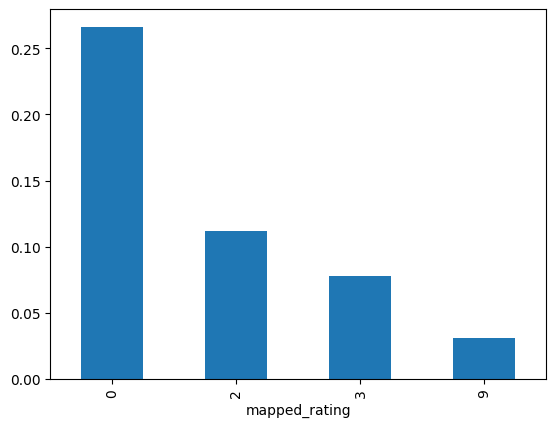

In [33]:
df.groupby('mapped_rating')['default'].mean().plot(kind='bar')

In [35]:
import json

# Ensure all boundaries are converted to native Python float or int
boundaries = [int(b) if isinstance(b, (np.integer, np.int64)) else float(b) for b in boundaries]

# Now safely write to JSON
with open('fico_rating_map.json', 'w') as f:
    json.dump(boundaries, f)

In [39]:
import numpy as np
import json

# Example list of bucket boundaries
# boundaries = [580, 620, 660, 700, 740, 780] — assumed to have NumPy types

# Convert to native Python types
boundaries = [
    int(b) if isinstance(b, (np.integer, np.int64))
    else float(b) if isinstance(b, (np.floating, np.float64))
    else b
    for b in boundaries
]

# Save to JSON
with open('fico_rating_map.json', 'w') as f:
    json.dump(boundaries, f)

print("Bucket boundaries saved successfully.")

Bucket boundaries saved successfully.


In [40]:
boundaries = [int(b) if isinstance(b, (int, np.integer))
              else float(b) if isinstance(b, (float, np.floating))
              else b
              for b in boundaries]

In [41]:
import numpy as np
import pandas as pd
import json

# Load your dataset
# df should contain: 'fico_score', 'default'


# Number of buckets
n_buckets = 5

# Step 1: Use KMeans or quantiles to create buckets
# Using quantiles here for simplicity
df['fico_bucket'], boundaries = pd.qcut(df['fico_score'], q=n_buckets, labels=False, retbins=True, duplicates='drop')

# Step 2: Convert bucket boundaries to native Python types (for JSON)
boundaries = [int(b) if isinstance(b, (np.integer, np.int64))
              else float(b) if isinstance(b, (np.floating, np.float64))
              else b
              for b in boundaries]

# Step 3: Save to JSON for Charlie’s model
with open("fico_rating_map.json", "w") as f:
    json.dump(boundaries, f)

print("✅ Bucket boundaries saved for FICO score quantization.")


✅ Bucket boundaries saved for FICO score quantization.


 (Optional) Use Log-Likelihood Optimization for Better PD Modeling
This is more advanced but more statistically sound for default modeling. It involves:

Defining a function to calculate log-likelihood for a bucket.

Using dynamic programming or a greedy algorithm to find boundary positions that maximize the log-likelihood.

Would you like me to help you implement the log-likelihood version with code?

✅ Reply with:

Yes, show me the log-likelihood-based quantization with code.

In [43]:
##Mapping FICO Scores to Buckets for Model TrainingApply Quantile-Based Bucketing (already done)
df['fico_bucket'], boundaries = pd.qcut(df['fico_score'], q=n_buckets, labels=False, retbins=True, duplicates='drop')

In [44]:
#If lower scores should have higher bucket numbers (i.e., 0 = worst), you can flip the scale:
df['fico_rating'] = (n_buckets - 1) - df['fico_bucket']

In [45]:
#Prepare Features and Target for ModelingLet’s assume you're building a simple classification model to predict default.

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define features and target
X = df[['fico_rating']]  # or 'fico_bucket' if you didn’t invert
y = df['default']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90      1630
           1       0.00      0.00      0.00       370

    accuracy                           0.81      2000
   macro avg       0.41      0.50      0.45      2000
weighted avg       0.66      0.81      0.73      2000



C:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [46]:
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

In [47]:
from sklearn.utils import resample

# Separate classes
df_majority = df[df['default'] == 0]
df_minority = df[df['default'] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

# Combine
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Proceed with training on df_balanced

In [48]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90      1630
           1       0.00      0.00      0.00       370

    accuracy                           0.81      2000
   macro avg       0.41      0.50      0.45      2000
weighted avg       0.66      0.81      0.73      2000



C:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [50]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.3f}")

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.